In [1]:
# Install (if not already installed)
!pip install yfinance pandas numpy matplotlib cvxpy


     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.9 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 649.3 kB/s eta 0:00:00
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.18.1-py3-none-any.whl
  Using cached websockets-15.0.1-cp311-cp311-win_amd64.whl.metadata (7.0 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
     --------------------------------- ----- 92.2/108.7 kB 2.6 MB/s eta 0:00:01
     ----------------------------------- -- 102.4/108.7 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 108.7/108.7 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp
from scipy.optimize import minimize


# Enable better plot visuals
#plt.style.use('seaborn')


In [17]:
# Define stock tickers and date range
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
start_date = '2018-01-01'
end_date = '2023-12-31'

# Download historical price data
data = yf.download(tickers, start=start_date, end=end_date)['Close']
print(data.columns)   # To see what columns are available
print(data.head())    # Preview the data


C:\Users\prana\AppData\Local\Temp\ipykernel_32592\33303115.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed

Index(['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT'], dtype='object', name='Ticker')
Ticker           AAPL       AMZN      GOOGL        META       MSFT
Date                                                              
2018-01-02  40.426815  59.450500  53.340599  180.430145  79.328537
2018-01-03  40.419788  60.209999  54.250641  183.662415  79.697723
2018-01-04  40.607529  60.479500  54.461376  183.324265  80.399162
2018-01-05  41.069866  61.457001  55.183544  185.830536  81.395966
2018-01-08  40.917316  62.343498  55.378376  187.252731  81.479027


In [18]:
# Calculate daily % returns
daily_returns = data.pct_change().dropna()

# Calculate annualized mean return
annual_returns = daily_returns.mean() * 252
annual_returns



Ticker
AAPL     0.309906
AMZN     0.219349
GOOGL    0.208735
META     0.204932
MSFT     0.303639
dtype: float64

In [19]:
# Annualized covariance matrix
cov_matrix = daily_returns.cov() * 252
cov_matrix


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Ticker,,,,,
AAPL,0.100343,0.069905,0.066703,0.077528,0.071554
AMZN,0.069905,0.125078,0.074074,0.091815,0.074206
GOOGL,0.066703,0.074074,0.097511,0.088813,0.072175
META,0.077528,0.091815,0.088813,0.182890,0.078538
MSFT,0.071554,0.074206,0.072175,0.078538,0.090745


In [21]:
num_portfolios = 10000
num_assets = len(tickers)
results = np.zeros((3, num_portfolios))
weights_record = []

risk_free_rate = 0.02

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)

    # Portfolio return & standard deviation
    port_return = np.dot(weights, annual_returns)
    port_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - risk_free_rate) / port_std_dev

    results[0, i] = port_return
    results[1, i] = port_std_dev
    results[2, i] = sharpe
     


In [22]:
# Objective function: negative Sharpe ratio (we minimize in scipy)
def neg_sharpe(weights):
    port_return = np.dot(weights, annual_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -((port_return - risk_free_rate) / port_std)

# Constraints: weights sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds: no shorting (0 <= weight <= 1)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess: equally distributed
initial_guess = num_assets * [1. / num_assets]

# Optimization
opt_result = minimize(neg_sharpe, initial_guess,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

# Extract optimized weights
opt_weights = opt_result.x
opt_return = np.dot(opt_weights, annual_returns)
opt_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix, opt_weights)))
opt_sharpe = (opt_return - risk_free_rate) / opt_volatility

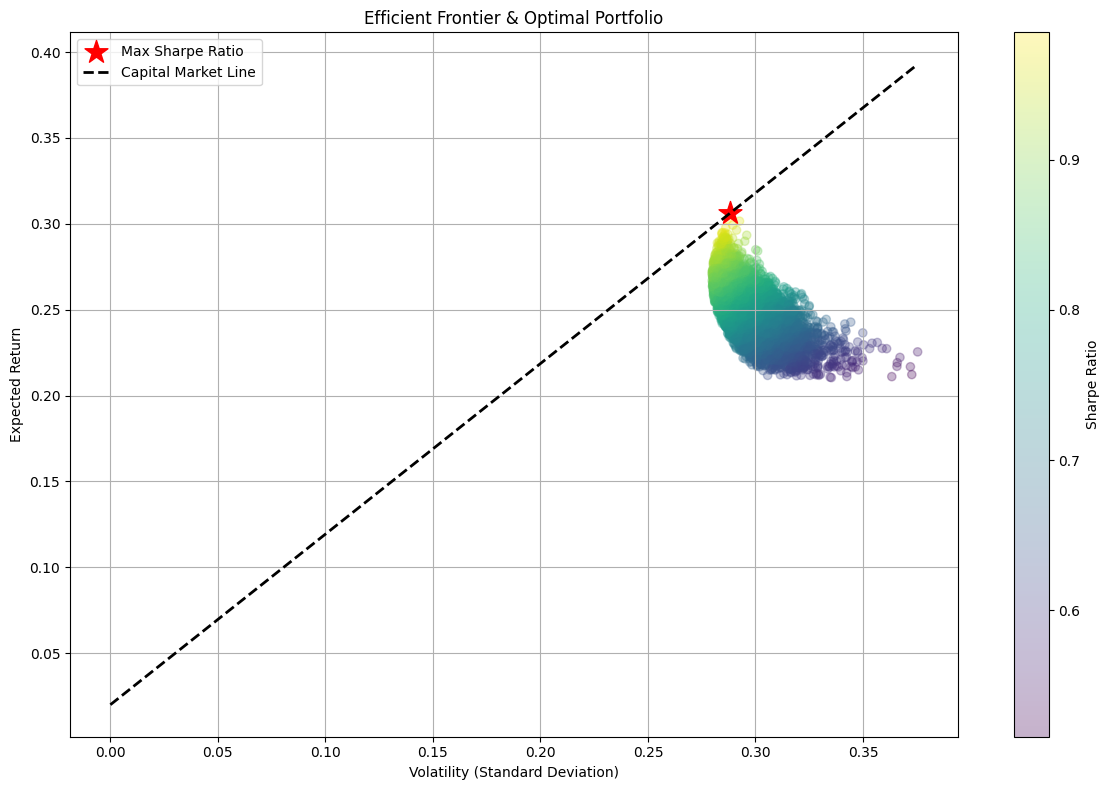

In [23]:
plt.figure(figsize=(12, 8))

# Efficient frontier
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

# Optimal portfolio
plt.scatter(opt_volatility, opt_return, color='red', marker='*', s=300, label='Max Sharpe Ratio')

# Capital Market Line (CML)
x = np.linspace(0, max(results[1, :]), 100)
cml_y = risk_free_rate + ((opt_return - risk_free_rate) / opt_volatility) * x
plt.plot(x, cml_y, color='black', linestyle='--', linewidth=2, label='Capital Market Line')

# Labels and aesthetics
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier & Optimal Portfolio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("efficient_frontier.png", dpi=300)
plt.show()


In [24]:
print("\n🔍 Optimal Portfolio Allocation (Max Sharpe Ratio):\n")
for i in range(num_assets):
    print(f"{tickers[i]}: {opt_weights[i]:.2%}")

print(f"\n📈 Expected Annual Return: {opt_return:.2%}")
print(f"📉 Annual Volatility: {opt_volatility:.2%}")
print(f"💹 Sharpe Ratio: {opt_sharpe:.2f}")



🔍 Optimal Portfolio Allocation (Max Sharpe Ratio):

AAPL: 43.75%
MSFT: 0.00%
GOOGL: 0.00%
AMZN: 0.00%
META: 56.25%

📈 Expected Annual Return: 30.64%
📉 Annual Volatility: 28.83%
💹 Sharpe Ratio: 0.99
